## import libraries

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

In [3]:
from scipy import stats

In [4]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
import pytrends
from pytrends.request import TrendReq
pytrends = TrendReq()

In [6]:
import censusdata

## Google Trends

### collect web searches

#### create keywords

In [8]:
keywords = ['college ranking', 'higher education',
            'college', 'university', 'colleges', 'universities',
            "bachelor's", 'undergraduate', 
            'public college','public university',
            'public colleges','public universities',
            'private college','private university',
            'private colleges','private universities']

In [9]:
len(keywords)

16

#### retrieve data from GoogleTrends

In [10]:
df_gt =pd.DataFrame()

timeframe = '2015-01-01 2019-12-31'

for i,keyword in enumerate(keywords):
    pytrends.build_payload(kw_list=[keyword],timeframe=timeframe,geo='US')
    df_temp = pytrends.interest_by_region()[keyword]
    df_gt = pd.concat([df_gt,df_temp], axis=1)

In [11]:
#reset index
df_gt.reset_index(names = ['GEO_NAME'], inplace = True)

#### Calculate composite search index

In [12]:
def GetReliability(df, var_list):
    if len(var_list) == 2:
        r = pg.corr(df[var_list[0]], df[var_list[1]])['r'][0]
        print(f"r = {r:.2f}")   
    elif len(var_list) >= 3:
        alpha = pg.cronbach_alpha(data=df[var_list])[0]
        print(f"alpha = {alpha :.2f}")
    else:
        print("error: more than two variables needed")

In [13]:
GetReliability(df_gt, keywords)

alpha = 0.90


In [14]:
def CalAve(df, new_var, var_list):
    df[new_var] = df[var_list].mean(axis = 1)
    return df.head()

In [15]:
CalAve(df_gt,'EduIndex',keywords)

,GEO_NAME,college ranking,higher education,college,university,colleges,universities,bachelor's,undergraduate,public college,public university,public colleges,public universities,private college,private university,private colleges,private universities,EduIndex
0,Alabama,63,39,89,84,62,50,67,51,36,37,58,40,58,66,38,34,54.5000
1,Alaska,26,30,42,43,45,53,96,37,29,37,0,0,0,0,0,0,27.3750
2,Arizona,33,35,58,54,47,57,81,40,41,29,36,32,48,49,29,47,44.7500
3,Arkansas,36,57,60,60,65,45,77,35,40,41,60,39,62,64,36,0,48.5625
4,California,65,30,68,42,60,80,81,64,37,26,46,51,82,87,67,100,61.6250


In [98]:
df_gt.to_csv('df_gt_061523.csv')

### create and save the master data

In [171]:
#add state-level covs other than expenditures
df_gt_cov = pd.read_csv('df_gt_cov.csv')
df_gt_cov['log10_income'] = np.log10(df_gt_cov['income'])

In [172]:
df_gt_master = df_gt.merge(df_gt_cov, on = 'GEO_NAME')

In [173]:
#add expenditure covs
df_exp_master = pd.read_csv('df_exp_master.csv')

In [174]:
df_exp_cov = df_exp_master.query('Year >= 2015 & Year <= 2019').groupby(by = ['State']).mean().reset_index().drop('Year', axis = 1)

In [175]:
df_gt_master = df_gt_master.merge(df_exp_cov, left_on = 'GEO_NAME', right_on = 'State')

In [176]:
#save data
df_gt_master.to_csv('df_gt_master.csv', index = False)

In [7]:
df_gt_master = pd.read_csv('df_gt_master.csv')

### Statistical Analysis on EduIndex

#### Pearson correlation

In [177]:
stats.pearsonr(df_gt_master.gini, df_gt_master.EduIndex)

PearsonRResult(statistic=0.5449065222297179, pvalue=3.561034133003929e-05)

In [178]:
stats.pearsonr(df_gt_master.income, df_gt_master.EduIndex)

PearsonRResult(statistic=0.42313908056926136, pvalue=0.0019771310009925112)

In [179]:
stats.pearsonr(df_gt_master.log10_income, df_gt_master.EduIndex)

PearsonRResult(statistic=0.4024416063472902, pvalue=0.0034153141083614197)

In [180]:
stats.pearsonr(df_gt_master.percent_librals, df_gt_master.EduIndex)

PearsonRResult(statistic=0.5132765087545081, pvalue=0.00011733120877181659)

In [181]:
stats.pearsonr(df_gt_master.population, df_gt_master.EduIndex)

PearsonRResult(statistic=0.3695360648363051, pvalue=0.007612676154450528)

In [182]:
stats.pearsonr(df_gt_master.k12_exp_per_pupil, df_gt_master.EduIndex)

PearsonRResult(statistic=0.426346487458723, pvalue=0.0018109285970553189)

In [183]:
stats.pearsonr(df_gt_master.he_funding_per_FTE, df_gt_master.EduIndex)

PearsonRResult(statistic=0.05499663382121717, pvalue=0.7014914049260784)

In [184]:
stats.pearsonr(df_gt_master.unemployment, df_gt_master.EduIndex)

PearsonRResult(statistic=-0.02903170074430168, pvalue=0.8397365563315635)

#### Regression (OLS)

##### correlations between covariates

In [11]:
df_gt_master[['gini','log10_income', 'percent_librals','population',
              'k12_exp_per_pupil', 'he_funding_per_FTE','unemployment']].corr()

,gini,log10_income,percent_librals,population,k12_exp_per_pupil,he_funding_per_FTE,unemployment
gini,1.000000,-0.086215,0.382338,0.415491,0.247510,0.190350,0.387807
log10_income,-0.086215,1.000000,0.606984,0.101573,0.624981,0.448878,-0.184561
percent_librals,0.382338,0.606984,1.000000,0.048197,0.635142,0.511692,0.002572
population,0.415491,0.101573,0.048197,1.000000,-0.048627,-0.092345,0.207943
k12_exp_per_pupil,0.247510,0.624981,0.635142,-0.048627,1.000000,0.492480,-0.015805
he_funding_per_FTE,0.190350,0.448878,0.511692,-0.092345,0.492480,1.000000,0.220735
unemployment,0.387807,-0.184561,0.002572,0.207943,-0.015805,0.220735,1.000000


In [9]:
df_gt_master.columns

Index(['GEO_NAME', 'college ranking', 'higher education', 'college',
       'university', 'colleges', 'universities', 'bachelor's', 'undergraduate',
       'public college', 'public university', 'public colleges',
       'public universities', 'private college', 'private university',
       'private colleges', 'private universities', 'EduIndex', 'GEO_ID',
       'gini', 'income', 'population', 'gini_5y', 'income_5y', 'population_5y',
       'vote_trump_percent', 'area_land', 'density', 'unemployment',
       'percent_librals', 'log10_income', 'log10_income_5y', 'State',
       'k12_exp_per_pupil', 'he_funding_per_FTE'],
      dtype='object')

##### OLS models

In [18]:
m_gt_edu= smf.ols('EduIndex ~ gini + log10_income + population + k12_exp_per_pupil +  he_funding_per_FTE + unemployment + percent_librals', 
               data = df_gt_master).fit() 
print(m_gt_edu.summary())

                            OLS Regression Results                            
Dep. Variable:               EduIndex   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     9.796
Date:                Thu, 20 Jul 2023   Prob (F-statistic):           3.11e-07
Time:                        21:42:02   Log-Likelihood:                -175.62
No. Observations:                  51   AIC:                             367.2
Df Residuals:                      43   BIC:                             382.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -464.2382    158

#### virsualization

In [61]:
import matplotlib as mpl
sns.set_theme(style="ticks", palette=['black'],font_scale=1)

COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

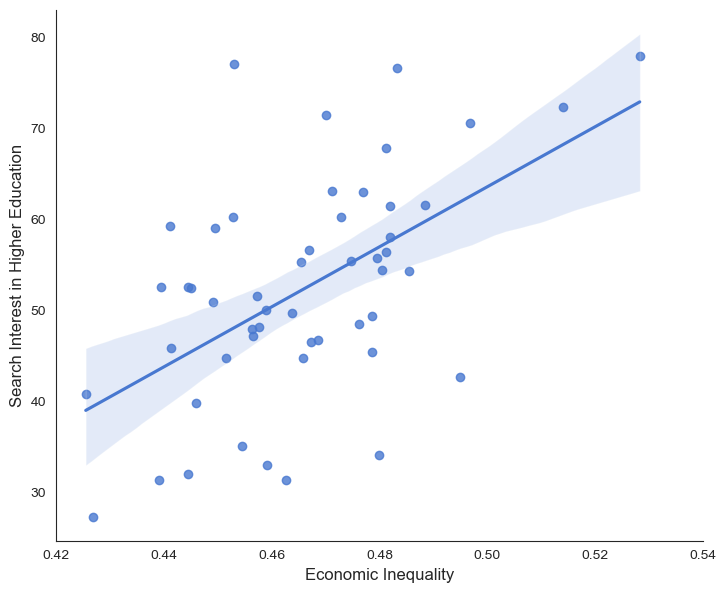

In [16]:
# Set a black and white color palette
sns.set_palette("muted")

# Set a white background
#sns.set_style("white")

sns.lmplot(x = "gini", y = "EduIndex", data = df_gt_master,
          height = 6, aspect = 1.2)

plt.xlabel('Economic Inequality', fontsize = 12)
plt.ylabel('Search Interest in Higher Education', fontsize = 12)

plt.yticks(np.arange(30, 90, step=10))
plt.xticks(np.arange(0.42, 0.54,step=0.02))

#plt.show()
plt.savefig('fig_gt.png', dpi=1000)